# Test Notebook for Confidence Regions Toolbox

## Import Packages

In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install nilearn
%pip install nibabel
%pip install dask
%pip install pyyaml

In [1]:
# Basic imports
import numpy
import yaml
import matplotlib.pyplot as plt

# Imports from Confidence Regions Toolbox
from generate import generate_CRs
from coverage import check_violations

# Import supporting functions
from lib.set_theory import *
from lib.boundary import *
from lib.regression import *

# Import data generation
from tests.generate_2d_data import *
from tests.generate_ni_data import *


## Data Generation

Initial parameters.

In [2]:
# Number of fields m
m = 3

# Get number of subjects
nSub = 80

# Get number of simulation realizations
nReals = 100

# Get number of bootstraps
nBoot = 5000

# Get Threshold
c = 2

# Get p values
p = np.linspace(0,1,21)

# Get the number of p-values we're looking at
nPvals = len(p)

# Get Tau
tau = 1/np.sqrt(nSub)

# Dimensions of simulated data
data_dim = np.array([nSub, 100,100])

Create some circular signals.

In [ ]:
# ---------------------------------------------------------------
# Mus
# ---------------------------------------------------------------
# Create empty specifications
mu_specs = {}

# Loop through mus, adding each field in turn
for i in np.arange(m):

    # New empty dict
    mu_specs['mu'+str(i+1)]={}

    # Mu type
    mu_specs['mu'+str(i+1)]['type'] = 'circle2D' 

    # Mu FWHM
    mu_specs['mu'+str(i+1)]['fwhm'] = np.array([5,5])

    # Mu r
    mu_specs['mu'+str(i+1)]['r'] = 40

    # Mu magnitude
    mu_specs['mu'+str(i+1)]['mag'] = 3

    # Get some evenly spaced center points
    centers = circle_points(np.array([25]),np.array([m]))

    # Mu center
    mu_specs['mu'+str(i+1)]['center'] = centers[i,:].astype(np.int)

# ---------------------------------------------------------------
# Epsilons
# ---------------------------------------------------------------
# Create empty specifications
noise_specs = {}

# Loop through noises, adding each field in turn
for i in np.arange(m):

    # New empty dict
    noise_specs['noise'+str(i+1)]={}

    # Add FWHM
    noise_specs['noise'+str(i+1)]['FWHM'] = np.array([0, 3, 3])

    # Add type
    noise_specs['noise'+str(i+1)]['type'] = 'homogen'

Generate the data.

In [ ]:
for i in np.arange(m):

    # ----------------------------------------------------------------
    # Data generation
    # ----------------------------------------------------------------

    # Obtain noise
    noise = get_noise(noise_specs['noise'+str(i+1)], data_dim)

    # Obtain mu
    mu = get_mu(mu_specs['mu'+str(i+1)], data_dim)

    # Create the data
    data = mu + noise

    # Save mus
    if i == 0:
        mus = np.array(mu)
    else:
        mus = np.concatenate((mus,mu),axis=0)

    # Combine data
    if i == 0:
        datas = np.array(data.reshape(1,*(data.shape)))
    else:
        datas = np.concatenate((datas,data.reshape(1,*(data.shape))),axis=0)

## Make Some Plots

In [ ]:
# Data for the "5th" subject
plt.imshow(np.mean(datas,axis=1)[2,:,:])
plt.colorbar()

## Generate Confidence Regions

In [ ]:
# Output directory
out_dir = '/home/tommaullin/Documents'

# Generate Confidence Regions
FcHat_minus, FcHat_plus, FcHat, a = generate_CRs(datas, c, p, out_dir)

In [ ]:
i = 20

print(a[i],p[i])
plt.imshow(1*FcHat_plus[i,:,:]+1*FcHat+1*FcHat_minus[i,:,:])
plt.colorbar()


In [ ]:
print(a[i])
plt.imshow(1*FcHat_plus[i,:,:]-1*FcHat_minus[i,:,:])
plt.colorbar()

## Assess Coverage

In [ ]:
# Get Fc
Fc = mu > c


In [ ]:
# Get the results
results = check_violations(FcHat_plus, FcHat_minus, datas, mus, c, tau, a)

In [ ]:
results[1]

## Assess Coverage over Repeated Runs

In [1]:
import time

# Set the number of repetitions
nReps = 1000

# Loop through the repetitions
for j in np.arange(nReps):
    print(j)
    
    # Time data generation
    start = time.time()

    for i in np.arange(m):
        # Obtain noise
        noise = get_noise(noise_specs['noise'+str(i+1)], data_dim)

        # Obtain mu
        mu = get_mu(mu_specs['mu'+str(i+1)], data_dim)

        # Create the data
        data = mu + noise

        # Save mus
        if i == 0:
            mus = np.array(mu)
        else:
            mus = np.concatenate((mus,mu),axis=0)

        # Combine data
        if i == 0:
            datas = np.array(data.reshape(1,*(data.shape)))
        else:
            datas = np.concatenate((datas,data.reshape(1,*(data.shape))),axis=0)
    
    # Time data generation
    end = time.time()
    #print(end - start)

    # Time confidence region generation
    start = time.time()

    # Generate Confidence Regions
    FcHat_minus, FcHat_plus, FcHat, a = generate_CRs(datas, c, p, out_dir)

    # Time confidence region generation
    end = time.time()
    #print(end - start)

    # Time violation checking
    start = time.time()

    # Get the results
    results = check_violations(FcHat_plus, FcHat_minus, datas, mus, c, tau, a)

    # Time violation checking
    end = time.time()
    #print(end - start)

    #print(results)
    # Average the results
    if j == 0:
        avg_results = np.array(results[0])
    else:
        # Concatenate the results
        concat_results = np.concatenate((avg_results.reshape(1,np.prod(avg_results.shape)),
                                        results[0].reshape(1,np.prod(avg_results.shape))),axis=0)
        # Avergae the results
        avg_results = np.mean(concat_results,axis=0)


NameError: name 'np' is not defined

In [ ]:
# Plot average results against p
plt.plot(p,avg_results)
plt.xlabel('p')
plt.ylabel('Average number of violations')
plt.title('Average number of violations against p')
plt.show()

### NeuroImaging Example

First, we generate some test data.

In [2]:
# Parameters for data generation
n = 30
p = 3
out_dir = "C:\\Users\\user\\Documents\\ConfSets_Rehaul\\"#'/home/tommaullin/Documents/ConfSets_Rehaul/'

# Generate some test data
y_files, beta_files, X = generate_data(n, p, out_dir)

beta shape (reg):  (120, 120, 120, 3, 1)
Xbeta shape (reg):  (120, 120, 120, 30, 1)


Compute the mean and standard deviation images.

In [3]:
# Get the estimated betahat, sigmahat and residuals
betahat_files, var_betahat_files, resid_files = regression(y_files, X, out_dir, chunk_size=20)

chunk shapes:  (100, 100, 100, 20, 1) (1, 1, 1, 20, 3)
chunk shapes:  (100, 100, 100, 10, 1) (1, 1, 1, 10, 3)
chunk check:  True
beta shape (100, 100, 100, 3, 1)


We're going to use the first $\hat{\beta}$ as our signal, $\mu$.

In [4]:
# Get muhat and sigmahat
muhat_file = betahat_files[0]
sigmahat_file = var_betahat_files[0]
mu_file = beta_files[0]

# Threshold c
c = 2

# Get p values
p = np.linspace(0,1,21)

Let's try to generate some CRs.

In [5]:
# Generate CRs
FcHat_minus, FcHat_plus, FcHat, a_estBdry = generate_CRs(muhat_file, sigmahat_file, resid_files, c, p)

applying mask
applying mask
applying mask
applying mask
applying mask
applying mask
numpy time:  5.572208404541016


6.048818111419678 1.0


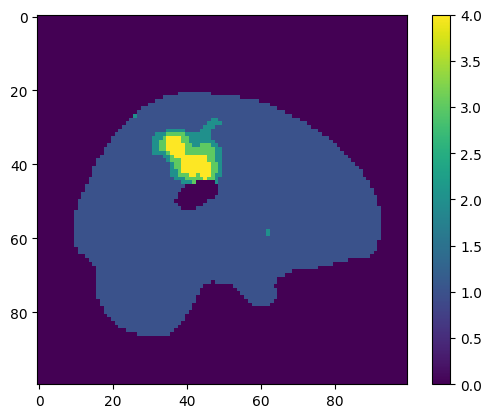

In [6]:
i = 20
slice = 40

# Read in muhat
muhat = np.array(nib.load(muhat_file).get_fdata())

# Make a mask
mask = muhat != 0

# Create the image
display_image = 1*mask[:,:,:,0] + 1*FcHat_plus[i,:,:,:] + 1*FcHat[:,:,:] + 1*FcHat_minus[i,:,:,:]

# Transpose the last two dimensions of the image
display_image = display_image.transpose((0,2,1))

# Flip the second dimension of the image
display_image = np.flip(display_image,axis=1)

print(a_estBdry[i],p[i])
plt.imshow(display_image[slice,:,:])
plt.colorbar()

(100, 100, 100, 1)
(100, 100, 100, 1)


c:\Users\user\Documents\ConfSets_Rehaul\.venv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == "__main__":


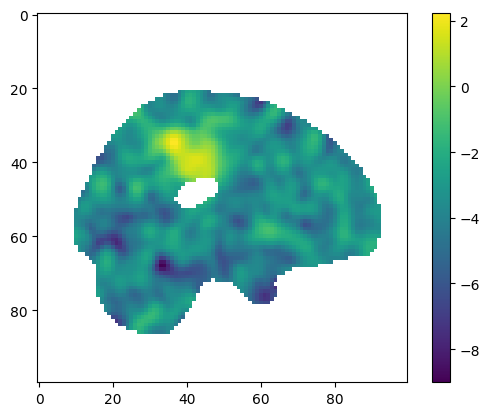

In [8]:
# Load in muhat and make an image of it
muhat = nib.load(muhat_file).get_fdata()
sigmahat = nib.load(sigmahat_file).get_fdata()

print(muhat.shape)
print(sigmahat.shape)

# Create the image
display_image = (muhat[:,:,:,0]-c)/sigmahat[:,:,:,0]

# Transpose the last two dimensions of the image
display_image = display_image.transpose((0,2,1))

# Flip the second dimension of the image
display_image = np.flip(display_image,axis=1)

# Make image
plt.imshow(display_image[slice,:,:])
plt.colorbar()
plt.show()

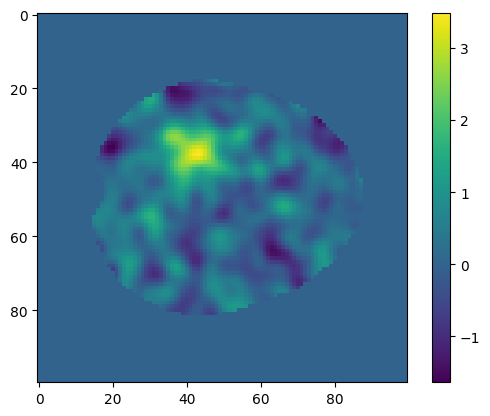

In [9]:
# Create the image
display_image = muhat[:,:,:,0]

# Transpose the last two dimensions of the image
display_image = display_image.transpose((0,2,1))

# Flip the second dimension of the image
display_image = np.flip(display_image,axis=1)

# Make image
plt.imshow(display_image[:,slice,:])
plt.colorbar()
plt.show()

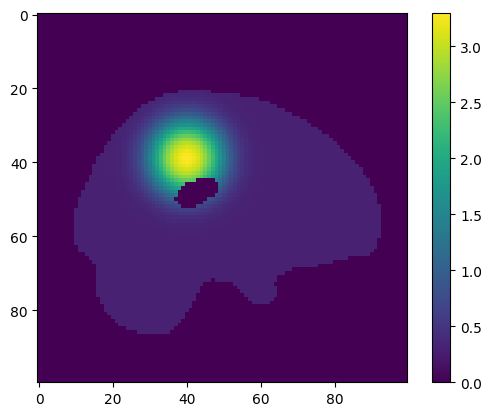

In [10]:
i = 20
slice = 40

# Read in mu
mu = nib.load(mu_file).get_fdata()

# Create the image
display_image = mu[:,:,:,0] + 0.3*mask[:,:,:,0]

# Transpose the last two dimensions of the image
display_image = display_image.transpose((0,2,1))

# Flip the second dimension of the image
display_image = np.flip(display_image,axis=1)

# Make image
plt.imshow(display_image[slice,:,:])
plt.colorbar()
plt.show()

(100, 100, 100, 1)
(100, 100, 100, 1)
2
3.0
40
applying mask
applying mask
applying mask
(array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36,

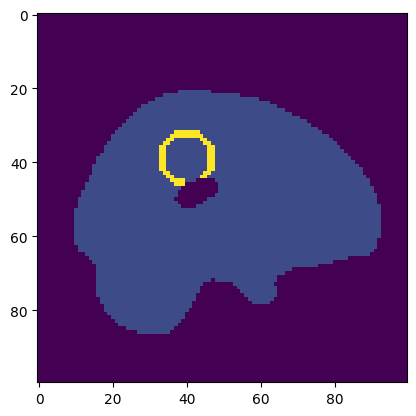

In [11]:
print(muhat.shape)
print(mu.shape)
print(c)
print(np.max(mu))
print(slice)
slice = 40

# Get boundary of FcHat
FcHat_bdry_map = get_bdry_map_combined(mu, c, mask=mask)

# Create the image
display_image = FcHat_bdry_map.reshape(FcHat_bdry_map.shape[:-1]) + 0.3*mask[:,:,:,0]

# Transpose the last two dimensions of the image
display_image = display_image.transpose((0,2,1))

# Flip the second dimension of the image
display_image = np.flip(display_image,axis=1)

# Make image
plt.imshow(display_image[slice,:,:])
print(np.where(FcHat_bdry_map))

In [12]:
total_time1 = 0
total_time2 = 0

for i in np.arange(10000):

    t1 = time.time()
    (2*np.random.randint(0,2,(100,100),dtype="int8")-1).dtype
    t2 = time.time()

    total_time1 += t2-t1

    t1 = time.time()
    (2*np.random.randint(0,2,(100,100))-1).dtype
    t2 = time.time()

    total_time2 += t2-t1

print(total_time1, total_time2)

1.0424575805664062 0.8517146110534668


In [13]:
print((2*np.random.randint(0,2,(100,100),dtype="int8")-1))

[[ 1 -1  1 ...  1  1  1]
 [-1  1 -1 ...  1 -1 -1]
 [-1  1 -1 ...  1  1  1]
 ...
 [-1  1 -1 ... -1  1  1]
 [-1  1 -1 ...  1 -1  1]
 [-1  1 -1 ...  1  1  1]]


In [13]:
mask = np.random.randint(0,2,(1,10,10),dtype="int8")==1
data = np.random.randn(10,10,10)


print(np.sum(mask))

# Return the elements of the data inside the mask, broadcasting the mask
print(data[np.broadcast_to(mask, data.shape)])
print(data[np.broadcast_to(mask, data.shape)].shape)    

50
[-8.42543836e-01  5.35296207e-01  1.21138801e+00  9.89366110e-01
  9.93961114e-01 -6.51552044e-01 -7.58053984e-01 -5.59268736e-01
  6.78994299e-01  1.62630782e-01  9.50431590e-01  2.46752844e-02
 -1.52628630e+00  1.40671601e-01  7.54000793e-02 -5.98056900e-02
  8.61623677e-01 -9.45890522e-02  8.13783830e-01 -1.08193812e+00
 -1.03562370e+00  1.08160326e+00 -8.07940985e-01  1.03967681e-01
 -1.22070340e+00  1.17909594e-01 -4.71104127e-02  7.44771526e-01
  1.84790491e-01 -1.10957144e+00  7.97370877e-01  4.24639516e-01
  7.17220311e-01 -3.96107820e-01 -9.06418399e-01  5.12996535e-01
 -1.10256768e+00  4.27036340e-01 -1.49660574e+00 -5.96710398e-01
 -4.16327081e-01  2.97731303e-01 -1.46018259e+00  3.27980814e-01
 -1.10152548e-01 -1.57192721e+00 -1.23672373e+00 -8.01331000e-01
  3.66237982e-01  2.80003578e-01  1.84779674e+00  4.89452455e-02
  6.43054078e-02 -8.39852109e-01 -8.69113848e-02  6.26520189e-01
 -1.28240232e-01  7.60995673e-01  1.34083234e-01 -2.02234178e-01
 -7.55615051e-01 -3.57

In [14]:
# Save confidence regions
out_dir = 'C:\\Users\\user\\Documents\\ConfSets_Rehaul\\src\\demo\\data\\example1\\'

# Create Fc
Fc = mu > c

# Save FcHat_minus
FcHat_minus_file = out_dir + 'Lower_CR_Example2.nii.gz'
addBlockToNifti(os.path.join(out_dir,FcHat_minus_file), FcHat_minus[20,...], np.arange(np.prod(FcHat_minus[20,...].shape)), volInd=0,dim=FcHat_minus[20,...].shape)

# Write to nifti
print(FcHat_minus.shape)
print(p[19])

# Save FcHat_plus
FcHat_plus_file = out_dir + 'Upper_CR_Example2.nii.gz'
addBlockToNifti(os.path.join(out_dir,FcHat_plus_file), FcHat_plus[20,...], np.arange(np.prod(FcHat_plus[20,...].shape)), volInd=0,dim=FcHat_plus[20,...].shape)

# Save FcHat
FcHat_file = out_dir + 'Estimated_Ac_Example2.nii.gz'
addBlockToNifti(os.path.join(out_dir,FcHat_file), FcHat, np.arange(np.prod(FcHat.shape)), volInd=0,dim=FcHat.shape)

# Save Fc
Fc_file = out_dir + 'True_Ac_Example2.nii.gz'
addBlockToNifti(os.path.join(out_dir,Fc_file), Fc[...,0], np.arange(np.prod(Fc[...,0].shape)), volInd=0,dim=Fc[...,0].shape)


# Save Fc
mask_file = 'C:\\Users\\user\\Documents\\ConfSets_Rehaul\\src\\demo\\data\\' + 'mask.nii.gz'
print(mask.shape)
addBlockToNifti(os.path.join(out_dir,mask_file), mask[...,0], np.arange(np.prod(mask[...,0].shape)), volInd=0,dim=mask[...,0].shape)


(21, 100, 100, 100)
0.9500000000000001
(100, 100, 100, 1)


In [15]:

# Save mu
mu_file = out_dir + 'True_Signal_Example2.nii.gz'
addBlockToNifti(os.path.join(out_dir,mu_file), mu, np.arange(np.prod(mu.shape)), volInd=0,dim=mu.shape)


# Save muhat
muhat_file = out_dir + 'Estimated_Signal_Example2.nii.gz'
addBlockToNifti(os.path.join(out_dir,muhat_file), muhat, np.arange(np.prod(muhat.shape)), volInd=0,dim=muhat.shape)

# Read in a Y instance
y_instance = nib.load(y_files[0]).get_fdata()

# Save a Y instance
y_file = out_dir + 'Data_Instance_Example2.nii.gz'
addBlockToNifti(os.path.join(out_dir,y_file), y_instance, np.arange(np.prod(y_instance.shape)), volInd=0,dim=muhat.shape)
